### Проект 3 [Медицинские расходы]

Вам предоставляется набор данных, содержащий информацию о медицинских расходах. Набор данных уже разделен на ```train.csv``` и ```test.csv```. Файл ```data_description.txt``` содержит описание столбцов.

**Цель:** построить модели для прогнозирования **медицинских расходов** (```"charges"```).

Пожалуйста, включите подробные объяснения следующих шагов:

1. Очистка, предварительная обработка данных

2. Обучение и проверка моделей.

3. Сравнение моделей на основе метрик регрессии.

**Примечание:** вам **рекомендуется** искать другие алгоритмы машинного обучения в Интернете (не ограничиваясь материалом курса), но вы должны изучить и понять эти алгоритмы. Вы не можете удалить ни одну строку в файле ```test.csv```.

# **1. ОЧИСТКА ДАННЫХ**

## **1.1.  БЛОК ИМПОРТА**

In [1]:
from pandas import options
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# модули обучения и построения моделей
from src.utils import *
from src.plotter import *
from src.linear_regression import *
from src.forest import *
from src.encoders import *
from src.bayes_isotonic import *


## **1.2. ЗАГРУЗКА ДАННЫХ**

In [2]:
# присвоение данных
df_train = set_numbercolumn(df=load_data(file="./train.csv"), columnname="Id")
df_test  = set_numbercolumn(df=load_data(file="./test.csv"), columnname="Id")

## **1.3. ИССЛЕДОВАНИЕ ВВОДНЫХ ДАННЫХ**

### **1.3.1. `Тренировочные данные` 'train'**

1. При визуальном осмотре файла аномалий в виде непонятных и "грязных" данных не выявлено.
2. Вывод данных на экран и первичный сбор информации в выборке отсутствующих значений (NaN) не выявил.
3. Замечен выделяющийся у некоторых показателей в графе 'charges' порядок размерности (13 знаков после запятой).
4. Ход решения указан в соотвествующих шагах обработки выборки.

In [3]:
# тренировочная выборка
df_train

age     sex     bmi  children smoker     region      charges
Id                                                                
1      34    male  42.900         1     no  southwest   4536.25900
2      61  female  36.385         1    yes  northeast  48517.56315
3      60    male  25.740         0     no  southeast  12142.57860
4      44  female  29.810         2     no  southeast   8219.20390
5      40  female  29.600         0     no  southwest   5910.94400
...   ...     ...     ...       ...    ...        ...          ...
1201   44  female  27.500         1     no  southwest   7626.99300
1202   37  female  17.290         2     no  northeast   6877.98010
1203   21  female  25.800         0     no  southwest   2007.94500
1204   30    male  38.830         1     no  southeast  18963.17192
1205   55  female  32.395         1     no  northeast  11879.10405

[1205 rows x 7 columns]

#### 1.3.1.1. Статистика по типам данным

Требуется приведение типов для некоторых столбцов.

In [4]:
# статистика по типам данным
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1205 entries, 1 to 1205
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1205 non-null   int64  
 1   sex       1205 non-null   object 
 2   bmi       1205 non-null   float64
 3   children  1205 non-null   int64  
 4   smoker    1205 non-null   object 
 5   region    1205 non-null   object 
 6   charges   1205 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 75.3+ KB


#### 1.3.1.2. Выявление уникальных значений выборки

Результат с пустым значением уникальных значений для данной выборки свидетельствует о `большом наличии 'NaN-значений'`.

In [5]:
df_train.value_counts(dropna=False)

age  sex     bmi     children  smoker  region     charges    
19   male    30.590  0         no      northwest  1639.56310     2
18   female  20.790  0         no      southeast  1607.51010     1
47   female  33.915  3         no      northwest  10115.00885    1
     male    25.460  2         no      northeast  9225.25640     1
             25.410  1         yes     southeast  21978.67690    1
                                                                ..
30   male    35.300  0         yes     southwest  36837.46700    1
             31.570  3         no      southeast  4837.58230     1
             31.400  1         no      southwest  3659.34600     1
             28.690  3         yes     northwest  20745.98910    1
64   male    39.160  1         no      southeast  14418.28040    1
Name: count, Length: 1204, dtype: int64

#### 1.3.1.3. Описание выборки с числовыми типами данных

In [6]:
# Предварительное неполное описание выборки
df_train.describe()

age          bmi     children       charges
count  1205.000000  1205.000000  1205.000000   1205.000000
mean     38.913693    30.675950     1.103734  13135.971538
std      13.904128     6.122464     1.211117  12029.499221
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26.220000     0.000000   4670.640000
50%      39.000000    30.400000     1.000000   9283.562000
75%      51.000000    34.770000     2.000000  16577.779500
max      64.000000    53.130000     5.000000  63770.428010

#### **1.3.1.3.1. Графическое представление тренировочной выборки**

Высокое значение `std` для 'charges' говорит о высоком разбросе величины взноса во всём обучаемом диапазоне. График концентрации (правая грань) показывает моду справа, оставляя слева аномальное наименьшее распределение взносов. При этом даже со стороны выбросов наблюдаются свои моды и прогибы в графике, что говорит о неравномерности распределения данных в этом диапазоне.

Такое распределение данных говорит о нелинейности зависимости величины взноса от других параметров.

Зависимость 'charges' от параметров будет показано в разделе обучения моделей.

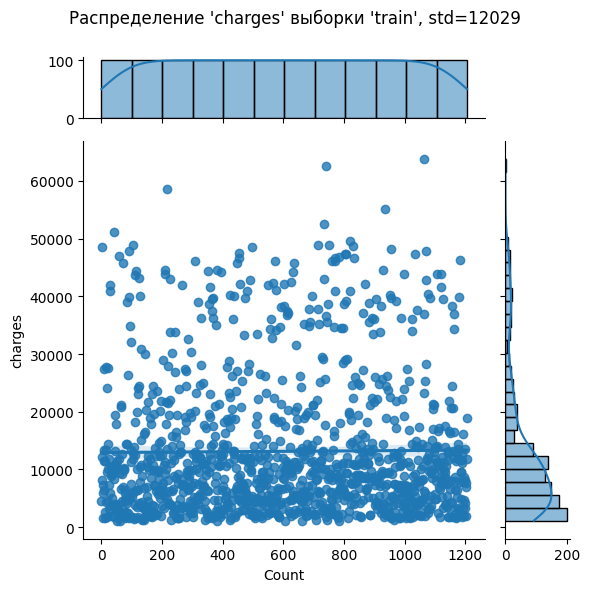

In [7]:
# Распределение 'charges'
g = sns.jointplot(df_train['charges'], kind="reg", marginal_ticks=True);
g.fig.suptitle(f"Распределение 'charges' выборки 'train', std={int(df_train['charges'].std())}");
g.fig.tight_layout();
g.fig.subplots_adjust(top=0.9); # отступ от графика для заголовка
plt.xlabel("Count");


#### **1.3.1.4. Пустые значения в таблице**

##### 1.3.1.4.1. Определение количества и названия пустых значений

Отсутствующие данных в выборке **не выявлены**.

In [8]:
# определение количества пустых значений
df_train.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### 1.4.2. Кодирование категорийных данных способом '**Linear Encoding**'

In [9]:
# список категорийных столбцов
category_list = list(df_train.dtypes[df_train.dtypes == object].keys())

#### 1.4.2.1. Закодированные данные

In [10]:
# закодированные данные
sc_x, sc_y, train_linear_dict, df_train_linear_encoded = get_encoded_data(df_data=df_train, isTrain=True)  # train
test_linear_dict, df_test_linear_encoded = get_encoded_data(df_data=df_test, sc_x=sc_x, sc_y=sc_y, isTrain=False)              # test

Кодирование требуется только для категорийных столбцов. Набор данных в этих столбцах даёт возможность использовать `Label Encoding`. Далее будет сделана процедура масштабирования всех значений. Для этого написан ряд функций в соотыетствующих модулях проекта.

In [11]:
df_test_linear_encoded

age       sex       bmi  children    smoker    region   charges
Id                                                                       
1    1.301327 -1.002493  0.079094 -0.911714  1.994828 -0.469552  2.531744
2    1.589131 -1.002493  1.376496  0.740339 -0.501296  1.346854  0.091405
3    1.589131  0.997513 -1.147228 -0.911714 -0.501296 -1.377756 -0.000530
4    1.445229  0.997513 -0.159471  0.740339 -0.501296  0.438651 -0.017471
5   -1.432809 -1.002493 -0.293460 -0.911714  1.994828 -0.469552  0.383595
..        ...       ...       ...       ...       ...       ...       ...
129  1.229376  0.997513  1.572577 -0.911714 -0.501296  1.346854 -0.210702
130  1.589131 -1.002493 -1.411121 -0.911714 -0.501296 -1.377756  0.039951
131  0.725719 -1.002493  1.961471  0.740339 -0.501296  0.438651 -0.277357
132  0.294014  0.997513 -0.541829  1.566366 -0.501296 -1.377756 -0.376710
133 -1.360858  0.997513  0.074192  0.740339 -0.501296  0.438651 -0.878997

[133 rows x 7 columns]

In [12]:
# закодированная тренировочная выборка
df_train_linear_encoded

age       sex       bmi  children    smoker    region   charges
Id                                                                        
1    -0.353545  0.997513  1.997419 -0.085687 -0.501296  1.346854 -0.715182
2     1.589131 -1.002493  0.932863 -0.085687  1.994828 -1.377756  2.942457
3     1.517180  0.997513 -0.806538 -0.911714 -0.501296  0.438651 -0.082614
4     0.365965 -1.002493 -0.141497  0.740339 -0.501296  0.438651 -0.408896
5     0.078161 -1.002493 -0.175811 -0.911714 -0.501296  1.346854 -0.600859
...        ...       ...       ...       ...       ...       ...       ...
1201  0.365965 -1.002493 -0.518953 -0.085687 -0.501296  1.346854 -0.458146
1202 -0.137692 -1.002493 -2.187274  0.740339 -0.501296 -1.377756 -0.520436
1203 -1.288907 -1.002493 -0.796734 -0.911714 -0.501296  1.346854 -0.925446
1204 -0.641349  0.997513  1.332378 -0.085687 -0.501296  0.438651  0.484610
1205  1.157425 -1.002493  0.280894 -0.085687 -0.501296 -1.377756 -0.104525

[1205 rows x 7 columns]

#### 1.4.2.2. Корреляция параметров тренировочной выборки

У параметров наблюдается слабая зависимость. Среди которой встречается негативная. Такие параметры будут обратно коррелировать при изменнии одного из них. Это требует дополнительной подготовки данных для выборки.

age       sex       bmi  children    smoker    region   charges
age       1.000000 -0.018853  0.100281  0.050940 -0.019542  0.008068  0.296395
sex      -0.018853  1.000000  0.053868  0.019666  0.089897  0.014659  0.064249
bmi       0.100281  0.053868  1.000000  0.020396  0.009689  0.144763  0.204654
children  0.050940  0.019666  0.020396  1.000000 -0.007022  0.004591  0.059493
smoker   -0.019542  0.089897  0.009689 -0.007022  1.000000  0.014830  0.785957
region    0.008068  0.014659  0.144763  0.004591  0.014830  1.000000  0.000332
charges   0.296395  0.064249  0.204654  0.059493  0.785957  0.000332  1.000000

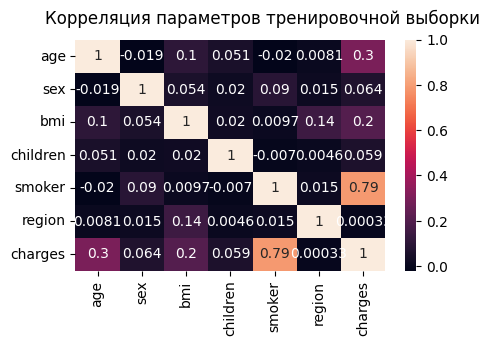

In [13]:
# визуализация корреляции выборки 'train'
fig, ax = plt.subplots(figsize=(5,3))
df_train_corr = df_train_linear_encoded.corr()
sns.heatmap(data=df_train_corr, annot=True, ax=ax);
fig.suptitle("Корреляция параметров тренировочной выборки")

df_train_corr

In [14]:
df_train_corr.describe()

age       sex       bmi  children    smoker    region   charges
count  7.000000  7.000000  7.000000  7.000000  7.000000  7.000000  7.000000
mean   0.202470  0.174784  0.219093  0.164009  0.267687  0.169606  0.344440
std    0.368408  0.365655  0.351258  0.369395  0.433005  0.369710  0.392568
min   -0.019542 -0.018853  0.009689 -0.007022 -0.019542  0.000332  0.000332
25%   -0.005393  0.017162  0.037132  0.012128  0.001334  0.006329  0.061871
50%    0.050940  0.053868  0.100281  0.020396  0.014830  0.014659  0.204654
75%    0.198338  0.077073  0.174709  0.055216  0.437927  0.079797  0.541176
max    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000

In [15]:
df_train_corr.median()

age         0.050940
sex         0.053868
bmi         0.100281
children    0.020396
smoker      0.014830
region      0.014659
charges     0.204654
dtype: float64

#### 1.4.2.3. Определение наиболее скоррелированных параметров к 'charges' тренировочной выборки.

По знаяениям median для коэффициентов корреляции принято решение оставить все столбцы.

Так как параметров не очень много, из выборки есть смысл удалить только столбцы с отрицательной корреляцией (если такие имеются).


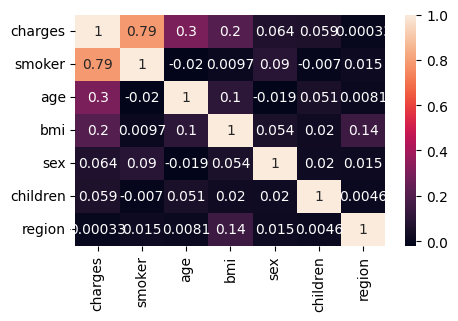

In [16]:
# наиболее коррелированные параметры с 'charges'
important_list = df_train_corr.loc[df_train_corr["charges"] > 0, "charges"].sort_values(ascending=False).index.to_list()

# визуализация корреляции выборки 'train'
fig, ax = plt.subplots(figsize=(5,3))
df_corr_large = df_train_linear_encoded[important_list].corr()
sns.heatmap(data=df_corr_large, annot=True, ax=ax);


In [17]:
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
df_FINAL_TRAIN = df_train_linear_encoded[important_list].copy()   # обучение
df_FINAL_TEST  = df_test_linear_encoded[important_list].copy()    # предсказание

In [18]:
df_FINAL_TRAIN

charges    smoker       age       bmi       sex  children    region
Id                                                                        
1    -0.715182 -0.501296 -0.353545  1.997419  0.997513 -0.085687  1.346854
2     2.942457  1.994828  1.589131  0.932863 -1.002493 -0.085687 -1.377756
3    -0.082614 -0.501296  1.517180 -0.806538  0.997513 -0.911714  0.438651
4    -0.408896 -0.501296  0.365965 -0.141497 -1.002493  0.740339  0.438651
5    -0.600859 -0.501296  0.078161 -0.175811 -1.002493 -0.911714  1.346854
...        ...       ...       ...       ...       ...       ...       ...
1201 -0.458146 -0.501296  0.365965 -0.518953 -1.002493 -0.085687  1.346854
1202 -0.520436 -0.501296 -0.137692 -2.187274 -1.002493  0.740339 -1.377756
1203 -0.925446 -0.501296 -1.288907 -0.796734 -1.002493 -0.911714  1.346854
1204  0.484610 -0.501296 -0.641349  1.332378  0.997513 -0.085687  0.438651
1205 -0.104525 -0.501296  1.157425  0.280894 -1.002493 -0.085687 -1.377756

[1205 rows x 7 columns]

***
# **2.** <span style="color: red;">**ПРОГНОЗИРОВАНИЕ МОДЕЛИ</span>**

### **2.1. Linear Regression**

#### **2.1.1. Simple Linear Regression**

Данная модель показывает очень плохие результаты предсказания медецинских расходов.

In [19]:
# словарь кодеров простой линейной регрессии
simple_train_linear_regressors_dict = train_simple_lin_regressors(df_data=df_FINAL_TRAIN, important=important_list)
print(simple_train_linear_regressors_dict)

{'smoker': LinearRegression(), 'age': LinearRegression(), 'bmi': LinearRegression(), 'sex': LinearRegression(), 'children': LinearRegression(), 'region': LinearRegression()}


In [20]:
df_FINAL_TEST

charges    smoker       age       bmi       sex  children    region
Id                                                                       
1    2.531744  1.994828  1.301327  0.079094 -1.002493 -0.911714 -0.469552
2    0.091405 -0.501296  1.589131  1.376496 -1.002493  0.740339  1.346854
3   -0.000530 -0.501296  1.589131 -1.147228  0.997513 -0.911714 -1.377756
4   -0.017471 -0.501296  1.445229 -0.159471  0.997513  0.740339  0.438651
5    0.383595  1.994828 -1.432809 -0.293460 -1.002493 -0.911714 -0.469552
..        ...       ...       ...       ...       ...       ...       ...
129 -0.210702 -0.501296  1.229376  1.572577  0.997513 -0.911714  1.346854
130  0.039951 -0.501296  1.589131 -1.411121 -1.002493 -0.911714 -1.377756
131 -0.277357 -0.501296  0.725719  1.961471 -1.002493  0.740339  0.438651
132 -0.376710 -0.501296  0.294014 -0.541829  0.997513  1.566366 -1.377756
133 -0.878997 -0.501296 -1.360858  0.074192  0.997513  0.740339  0.438651

[133 rows x 7 columns]

In [21]:
# округление в 'DataFrame'
format_in_dataframe(2)


# прогнозирование
df_predictions_linear = linear_validation(regressors=simple_train_linear_regressors_dict,
                                          sc_train_y=sc_y, linear_encoder_dict=test_linear_dict,
                                          data=df_FINAL_TEST)
df_predictions_linear

charges   smoker      age      bmi      sex  children   region
Id                                                                 
1   43578.94 31988.57 17773.91 13330.61 12361.49  12483.75 13134.09
2   14235.07  8398.35 18799.64 16523.34 12361.49  13665.59 13141.36
3   13129.60  8398.35 18799.64 10312.80 13906.61  12483.75 13130.46
4   12925.89  8398.35 18286.77 12743.53 13906.61  13665.59 13137.72
5   17748.51 31988.57  8029.43 12413.81 12361.49  12483.75 13134.09
..       ...      ...      ...      ...      ...       ...      ...
129 10602.39  8398.35 17517.47 17005.87 13906.61  12483.75 13141.36
130 13616.36  8398.35 18799.64  9663.39 12361.49  12483.75 13130.46
131  9800.89  8398.35 15722.44 17962.89 12361.49  13665.59 13137.72
132  8606.22  8398.35 14183.84 11802.60 13906.61  14256.51 13130.46
133  2566.47  8398.35  8285.87 13318.55 13906.61  13665.59 13137.72

[133 rows x 7 columns]

In [22]:
# округление в 'DataFrame'
format_in_dataframe(5)

# словарь с метриками всех моделей
metrics_dict = {}


print("МЕТРИКИ ПРОСТОЙ ЛИНЕЙНОЙ РЕГРЕССИЙ ПРЕДСКАЗАНИЯ 'charges'")
df_simple_linear_metrics = get_metrics(df_data=df_predictions_linear)

metrics_dict['simple'] = [df_simple_linear_metrics]
df_simple_linear_metrics



МЕТРИКИ ПРОСТОЙ ЛИНЕЙНОЙ РЕГРЕССИЙ ПРЕДСКАЗАНИЯ 'charges'


metrics         smoker             age             bmi             sex   
0          MSE 59801783.79001 147562103.49717 161339095.24029 165043157.77088  \
1         RMSE     7733.16131     12147.51429     12701.93274     12846.91238   
2          MAE     5687.43305      9522.66787      9429.63560      9257.50263   
3           R2        0.63221         0.09248         0.00775        -0.01503   
4  Adjusted_R2        0.62940         0.08555         0.00017        -0.02278   

         children          region  
0 162386763.80937 164434587.96067  
1     12743.10652     12823.20506  
2      9208.94540      9199.70467  
3         0.00130        -0.01129  
4        -0.00632        -0.01901

### **2.1.2. Анализ предсказания методом простой линейной регрессии**

О плохом качестве предсказания модели говорят:

1. **Низкие показатели** `Adjusted R2`.
2. **Большой разброс данных** на одиночных и общем графиках.

In [23]:
df_predictions_linear.columns.to_list()[1:]

['smoker', 'age', 'bmi', 'sex', 'children', 'region']

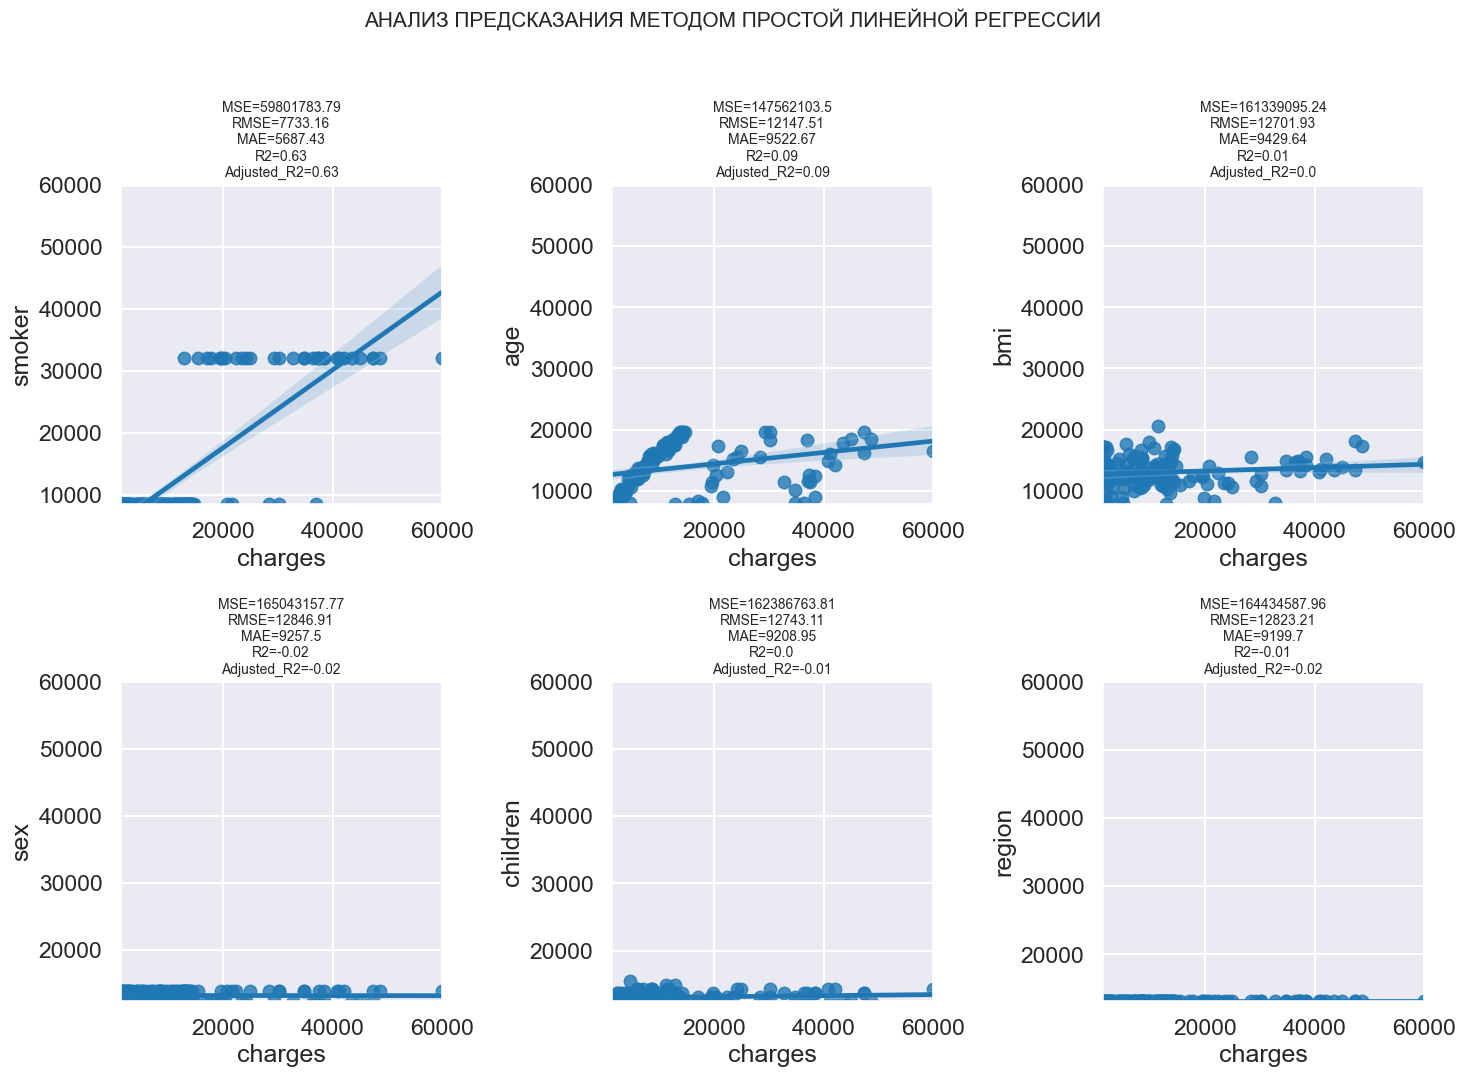

In [24]:
# АНАЛИЗ ПРЕДСКАЗАНИЯ МЕТОДОМ ПРОСТОЙ ЛИНЕЙНОЙ РЕГРЕССИИ
draw_predict_scatter(models_predictions=df_predictions_linear, df_metrics=df_simple_linear_metrics,
                     figsize=(15,15),
                     suptitlesize=15, titlesize=10,
                     y_suptitle=1.01,
                     suptitle="АНАЛИЗ ПРЕДСКАЗАНИЯ МЕТОДОМ ПРОСТОЙ ЛИНЕЙНОЙ РЕГРЕССИИ")
plt.tight_layout()


#### 2.1.3. Сравнение простой линейной регрессии для всех параметров

График демоснстрирует плохую обученность модели.

При этом есть интересная особенность выстроенных в линию всех параметров, кроме `smoker`. Этот факт может пригодится при обучении других моделей для данной выборки.

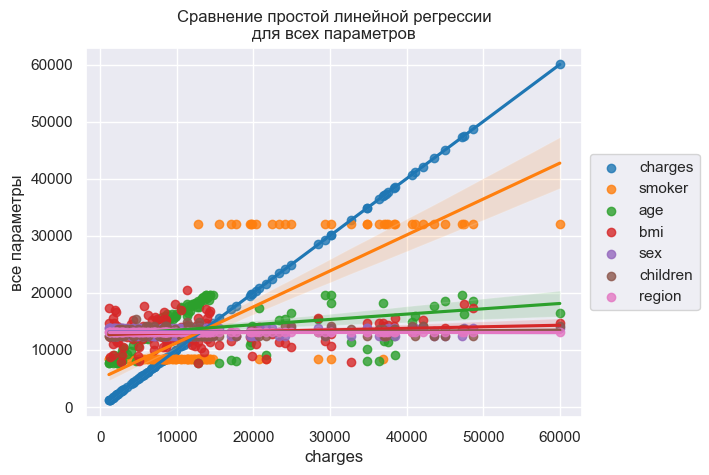

In [25]:
# Сравнение простой линейной регрессии для всех параметров
sns.set_context(context="notebook")
for colname in df_predictions_linear.columns.to_list():
    g = sns.regplot(data=df_predictions_linear, x="charges", y=colname, label=colname);
g.set_title("Сравнение простой линейной регрессии\nдля всех параметров");
g.set_ylabel("все параметры");
g.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [26]:
# # определение количества пустых значений
# df_FINAL_TEST.loc[df_FINAL_TEST.isna().any(axis=1)]

***
### **2.2. Multiple Linear Regression**

#### **2.2.1. Анализ предсказания методом множественной линейной регрессии**

О плохом качестве предсказания модели говорят:

1. Не смотря на то, что скопление предсказаний на графике прижимается к линии регрессии, значения метрик значительно отличается от того, чтобы на практике применять данную модель для предсказания цены 'charges'.

2. При этом отмечается улучшение показателя `Adjusted R2`.

In [27]:
# обученная модель множественной регрессии
multiple_linear_regressor = train_linear_regressor(df_data=df_FINAL_TRAIN, important=important_list[1:])

# прогнозирование
df_predictions_multiple_linear = linear_validation(regressors=multiple_linear_regressor,
                                                   sc_train_y=sc_y, linear_encoder_dict=train_linear_dict,
                                                   data=df_FINAL_TEST,
                                                   isSimple=False,
                                                   important=important_list[1:])

df_predictions_multiple_linear

charges  predict
Id                   
1      43578    16650
2      14235    20555
3      13129    16748
4      12925    18552
5      17748     6720
..       ...      ...
129    10602    20395
130    13616    14754
131     9800    19226
132     8606    14920
133     2566     9671

[133 rows x 2 columns]

In [28]:
# округление в 'DataFrame'
format_in_dataframe(2)

print("МЕТРИКИ ПРОСТОЙ ЛИНЕЙНОЙ РЕГРЕССИЙ ПРЕДСКАЗАНИЯ 'charges'")
df_multiple_linear_metrics = get_metrics(df_data=df_predictions_multiple_linear)
metrics_dict['multiple'] = [df_multiple_linear_metrics]
df_multiple_linear_metrics

МЕТРИКИ ПРОСТОЙ ЛИНЕЙНОЙ РЕГРЕССИЙ ПРЕДСКАЗАНИЯ 'charges'


metrics      predict
0          MSE 145030992.02
1         RMSE     12042.88
2          MAE      9501.90
3           R2         0.11
4  Adjusted_R2         0.10

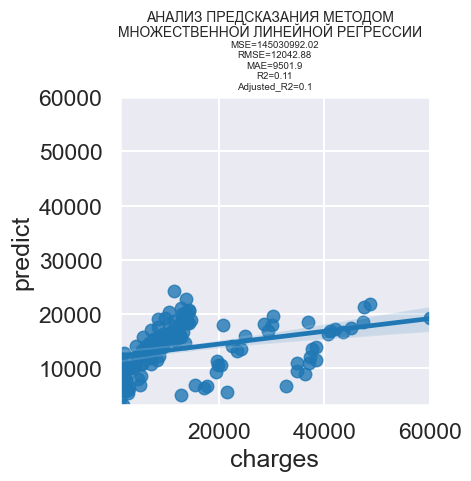

In [29]:
# АНАЛИЗ ПРЕДСКАЗАНИЯ МЕТОДОМ МНОЖЕСТВЕННОЙ ЛИНЕЙНОЙ РЕГРЕССИИ
draw_predict_scatter(models_predictions=df_predictions_multiple_linear,
                     df_metrics=df_multiple_linear_metrics,
                     figsize=(4,4),
                     titlesize=7,
                     suptitlesize=10,
                     y_suptitle=1.1,
                     suptitle="АНАЛИЗ ПРЕДСКАЗАНИЯ МЕТОДОМ\nМНОЖЕСТВЕННОЙ ЛИНЕЙНОЙ РЕГРЕССИИ")


***
### **2.3. Polynomial Multy Linear Regression**

Текущая модель по-прежнему **не подходит для предсказания** 'charges'. Не смотря на то, что не изменилось поведение графика регрессии при изменении параметров `degree`. Уменьшилось значения `RMSE` примерно в 2 разa. Метрика `Adjust_R2` при этом имеет среднее значение **0.6**, что лалеко от хороших показателей предсказния  'charges'. Это подтверждают графики.

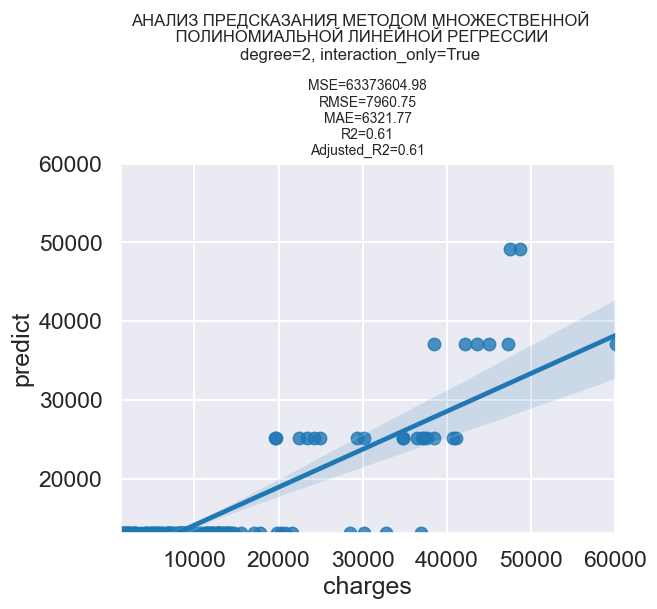

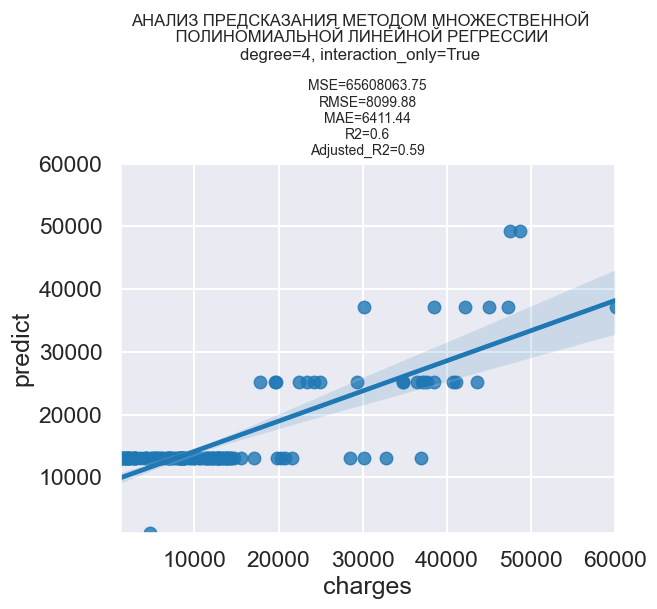

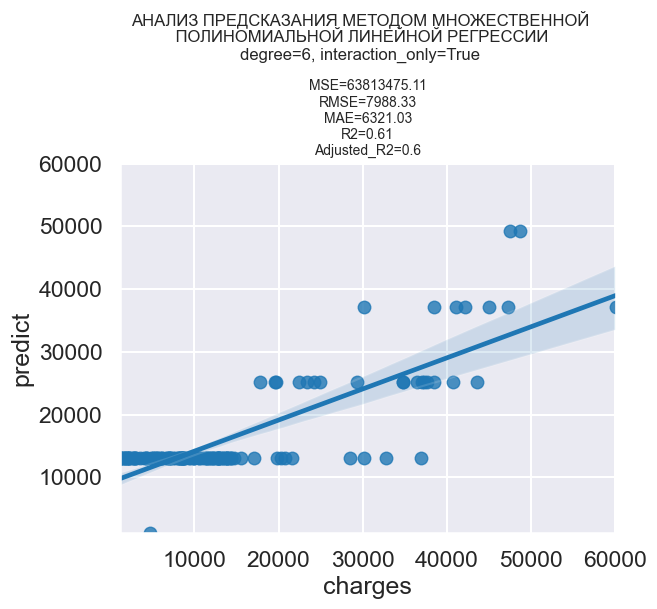

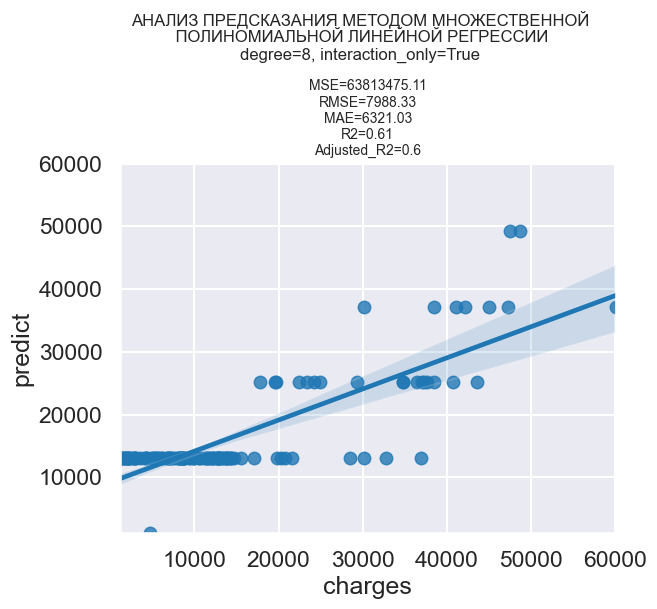

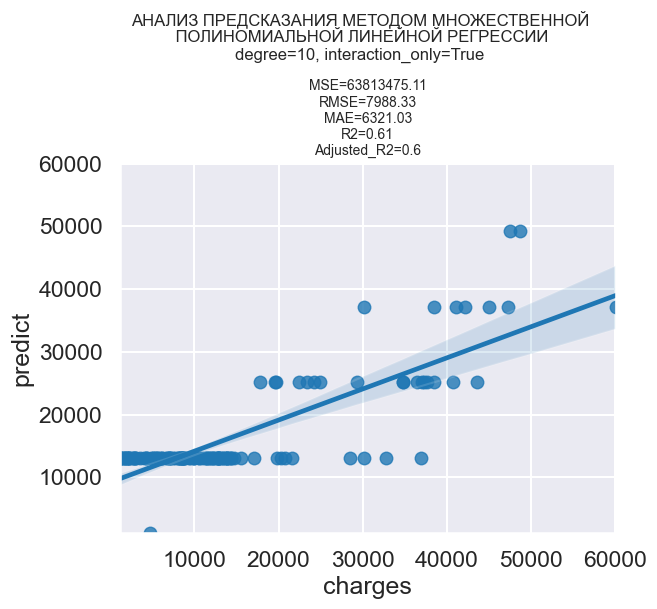

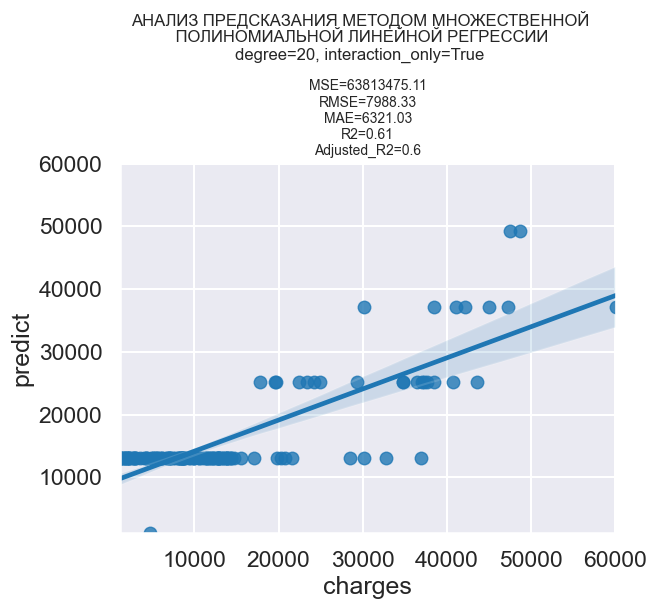

In [30]:
# ПОСТРОЕНИЕ ГРАФИКОВ СРАВНЕНИЯ ПРЕДСКАЗАНИЯ ПОЛИНОМИАЛЬНОЙ РЕГРЕССИИ

# список с метриками
metrics_list = {}

# 1. Диапазон 'degree=[2,10]'
for degree in range(2,11,2):
    _, _, df_polinomial_metrics = combination_polinomial(df_train=df_FINAL_TRAIN, df_test=df_FINAL_TEST,
                                                         sc_train_y=sc_y, parameters=important_list, degree=degree)
    metrics_list[degree] = df_polinomial_metrics


# 2. 'degree=20'
degree=20
_, _, df_polinomial_metrics = combination_polinomial(df_train=df_FINAL_TRAIN, df_test=df_FINAL_TEST,
                                                    sc_train_y=sc_y, parameters=important_list, degree=degree)
metrics_list[degree] = df_polinomial_metrics

# словарь метрик
metrics_dict['polinomial'] = metrics_list
# metrics_list.clear()




***
### **2.4. Random Forest**

Данная модель плохо предсказывает расходы 'charges'. У модели высокие ошибки отклонения не зависимо от комбинаций параметров. При этом предсказания уже близко прижимаются к целевому параметру, это подтверждает `Adjusted_R2`.

In [31]:
# ОБУЧЕННАЯ МОДЕЛЬ СЛУЧАЙНОГО ЛЕСА
multiple_forest_regressor = train_random_forest_regressor(data=df_FINAL_TRAIN, parameters=important_list, n_estimators=1, random_state=0)
# print(multiple_forest_regressor)

df_multiple_forest_regressor = random_forest_validation(model=multiple_forest_regressor, data=df_FINAL_TEST, sc_train_y=sc_y)
df_multiple_forest_regressor


charges  predict
Id                   
1   43578.94 44423.80
2   14235.07 13470.80
3   13129.60 12731.00
4   12925.89 12333.83
5   17748.51 17352.68
..       ...      ...
129 10602.39 20630.28
130 13616.36 13415.04
131  9800.89  8871.15
132  8606.22  7729.65
133  2566.47  3056.39

[133 rows x 2 columns]

#### **2.4.1. Построение графиков сравнения предсказания регрессии случайный лес**

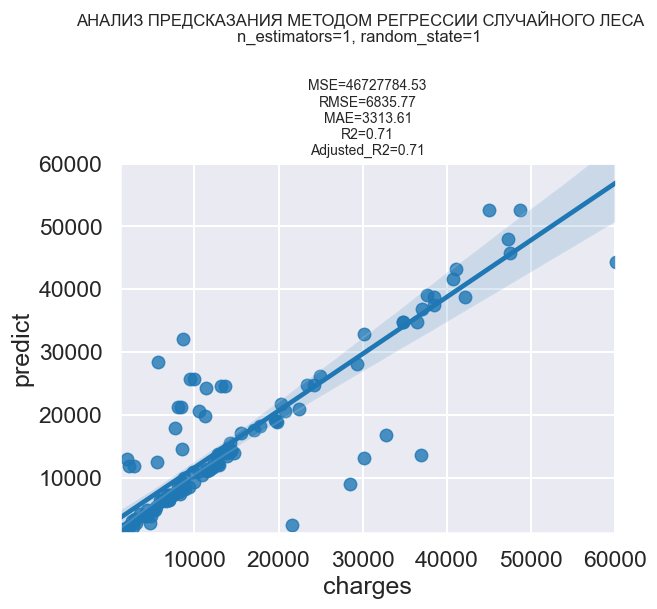

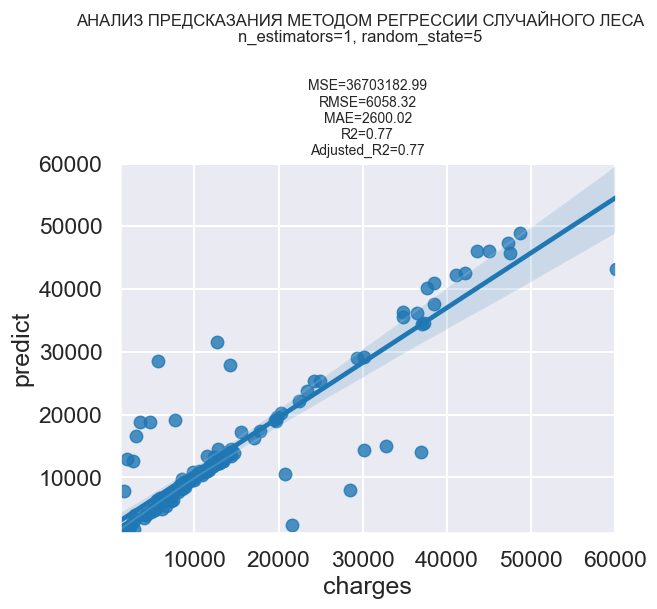

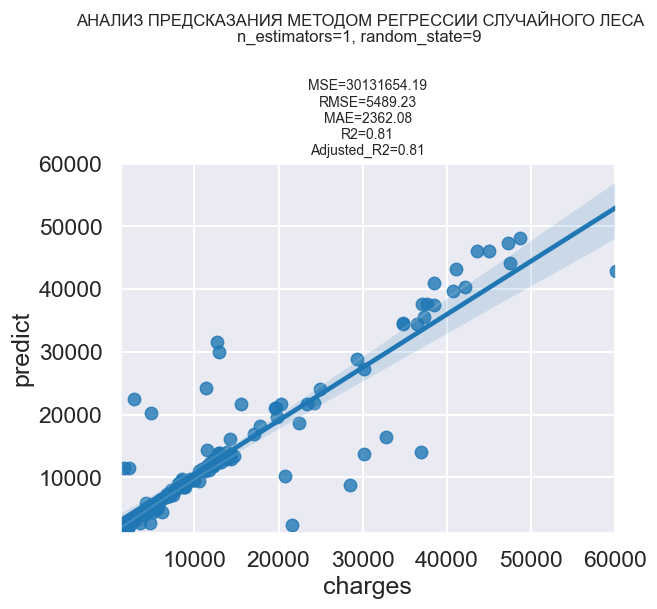

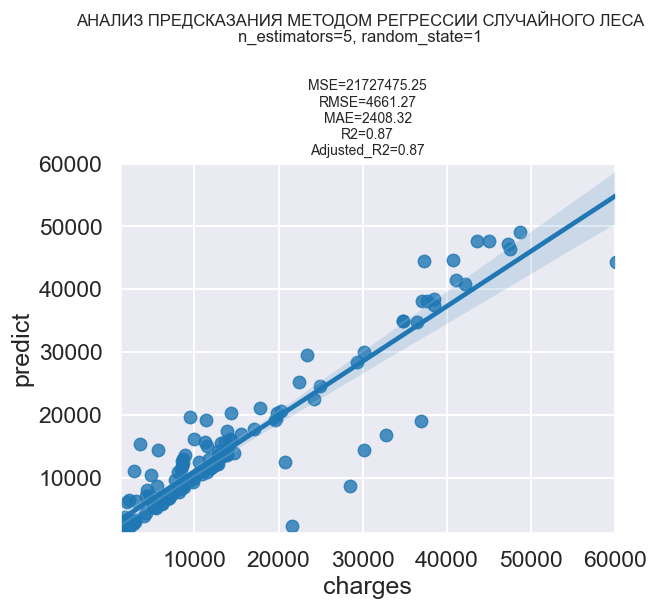

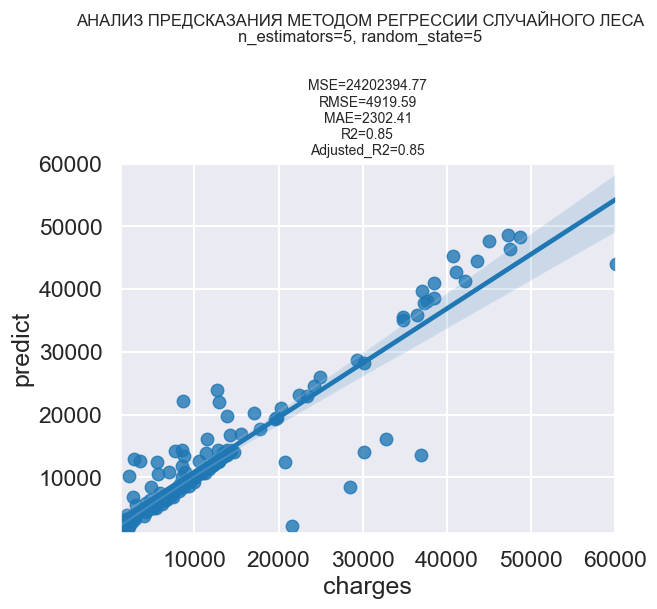

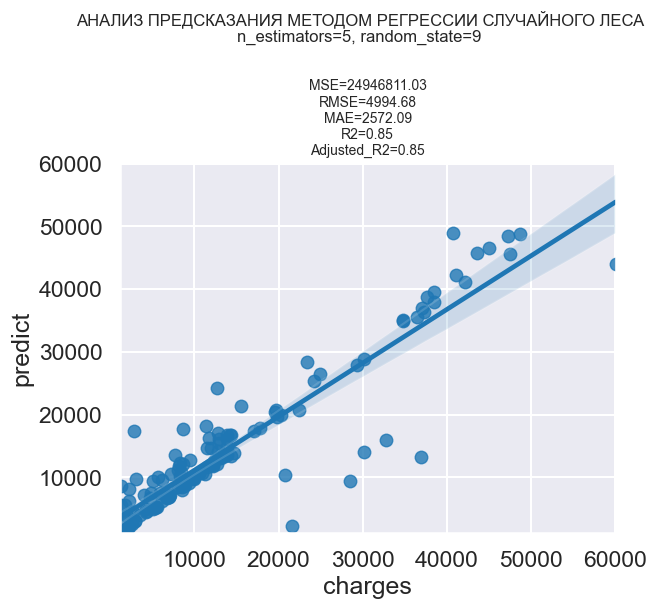

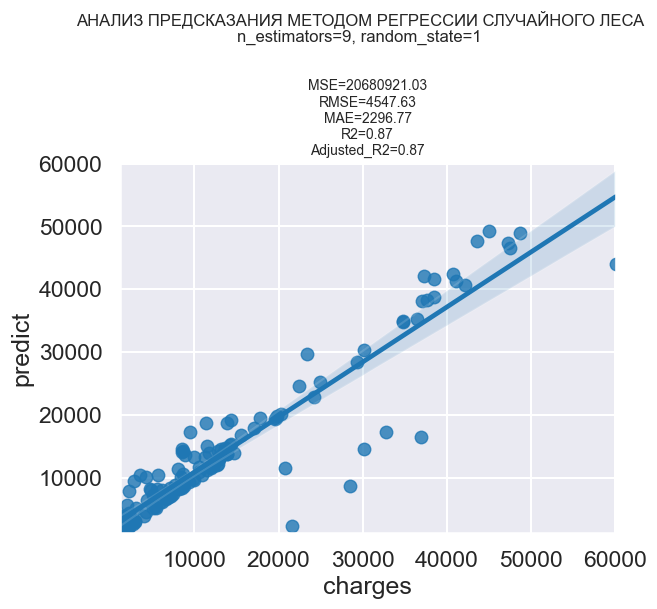

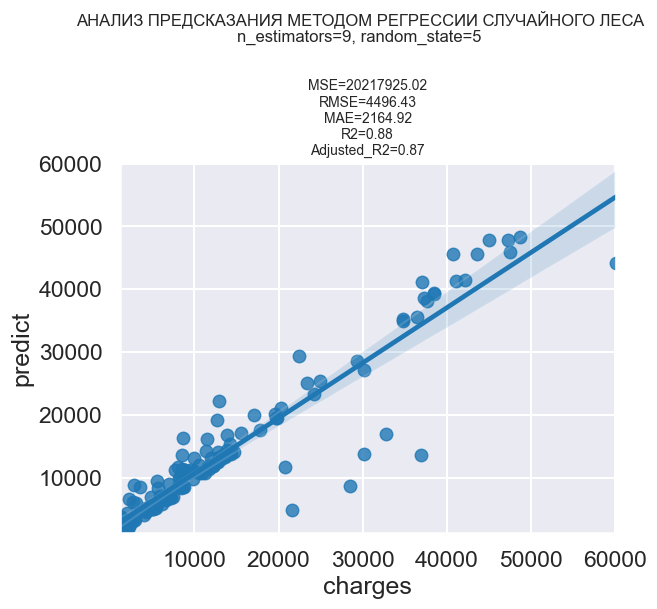

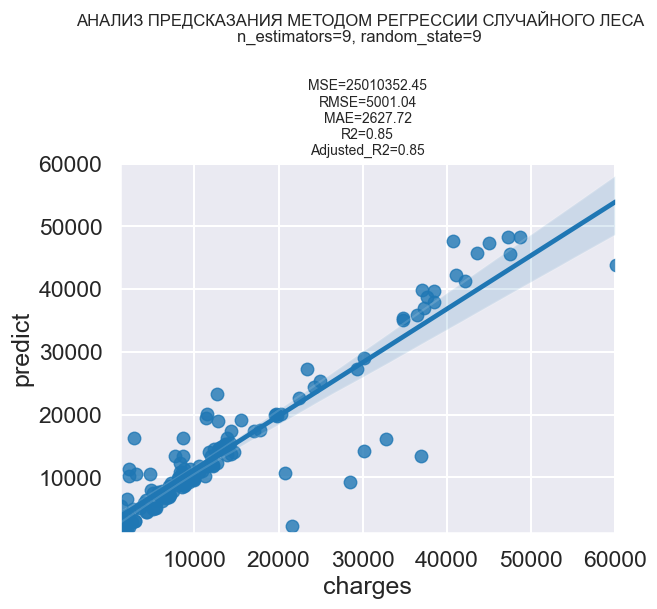

In [32]:
# словарь метрик леса
forest_metrics_dict = {}
# ПОСТРОЕНИЕ ГРАФИКОВ СРАВНЕНИЯ ПРЕДСКАЗАНИЯ РЕГРЕССИИ СЛУЧАЙНЫЙ ЛЕС
for n_estimators in range(1,11,4):
    for random_state in range(1,11,4):
        _, _, df_forest_metrics = combination_forest(df_train=df_FINAL_TRAIN, df_test=df_FINAL_TEST,
                                                     sc_train_y=sc_y, parameters=important_list,
                                                     n_estimators=n_estimators, random_state=random_state)
        forest_metrics_dict[f"{n_estimators}_{random_state}"] = df_forest_metrics
# словарь метрик
metrics_dict['forest'] = forest_metrics_dict

***
### **2.5. Decision Tree**

При различных комбинациях модель показывает результаты по метрикам хуже, чем у некоторых предыдущих моделей

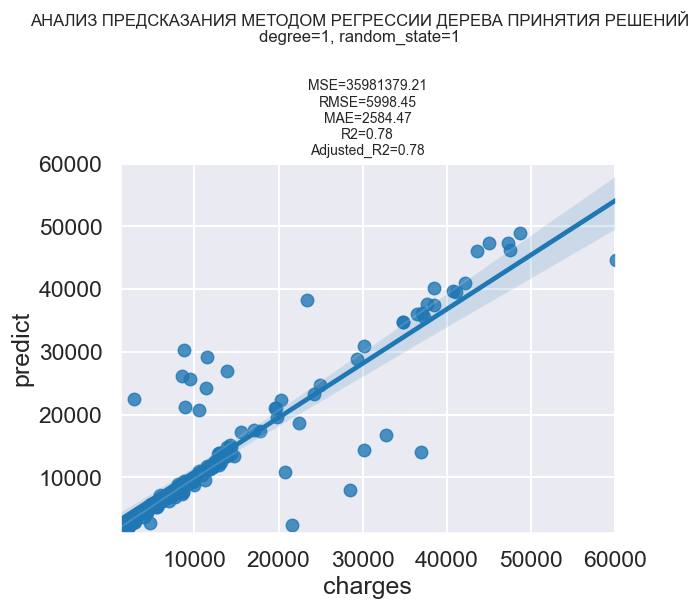

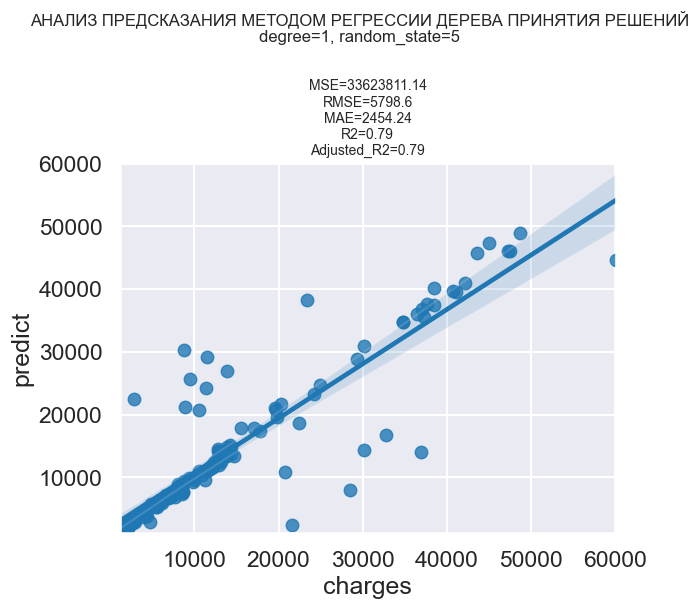

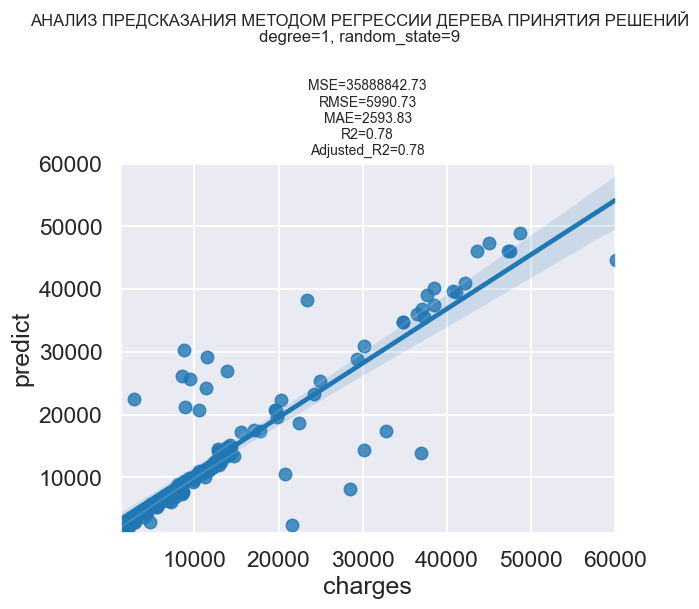

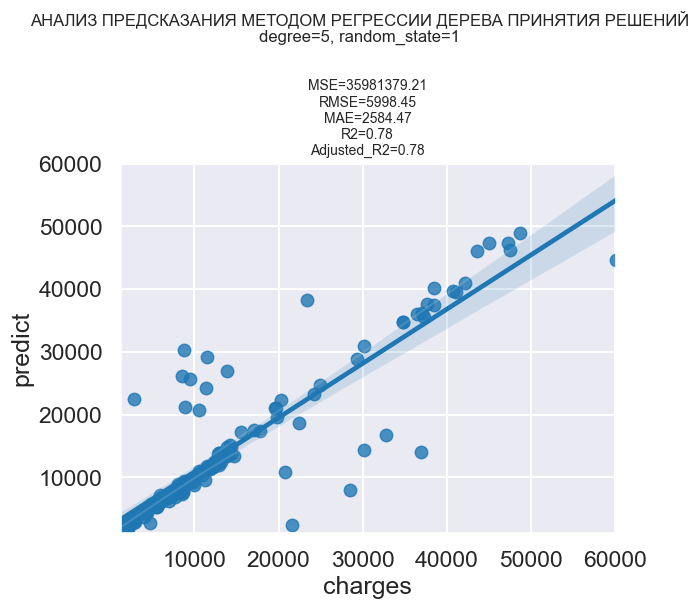

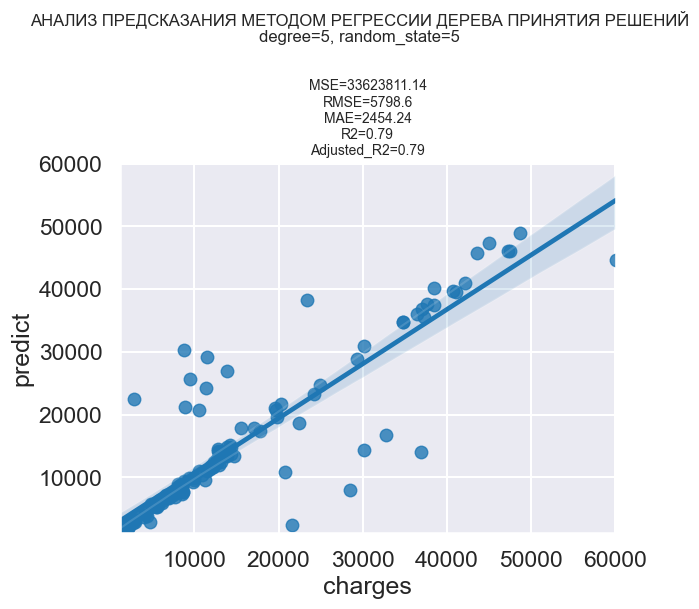

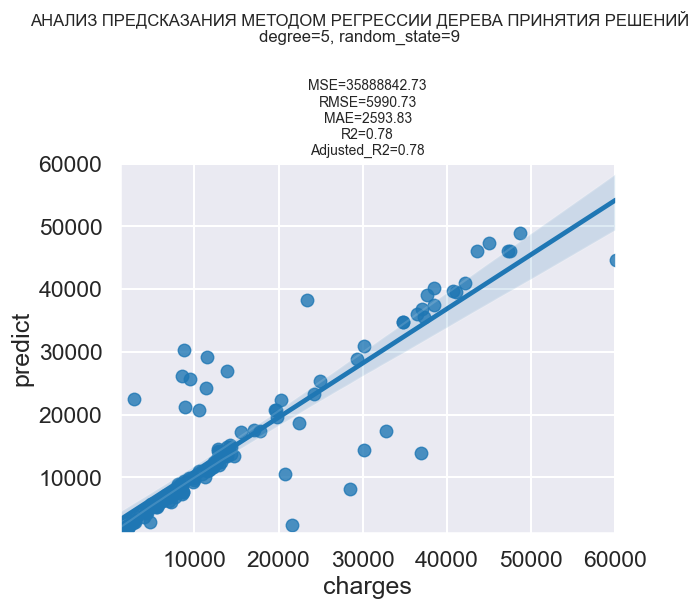

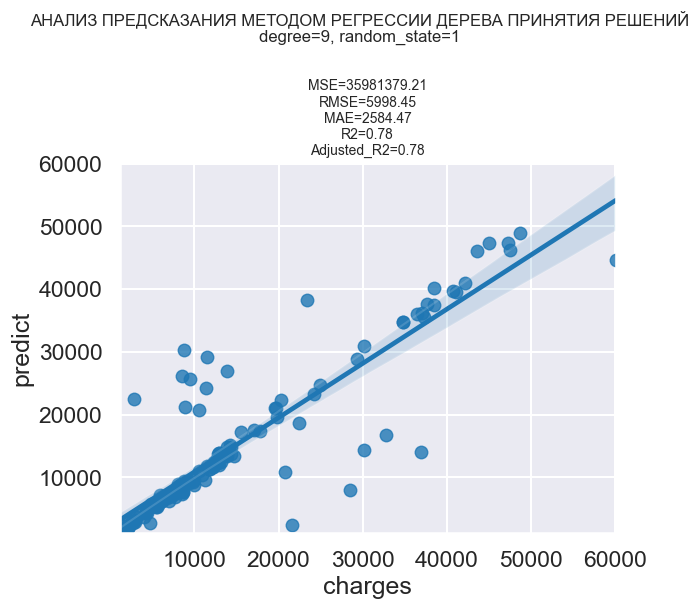

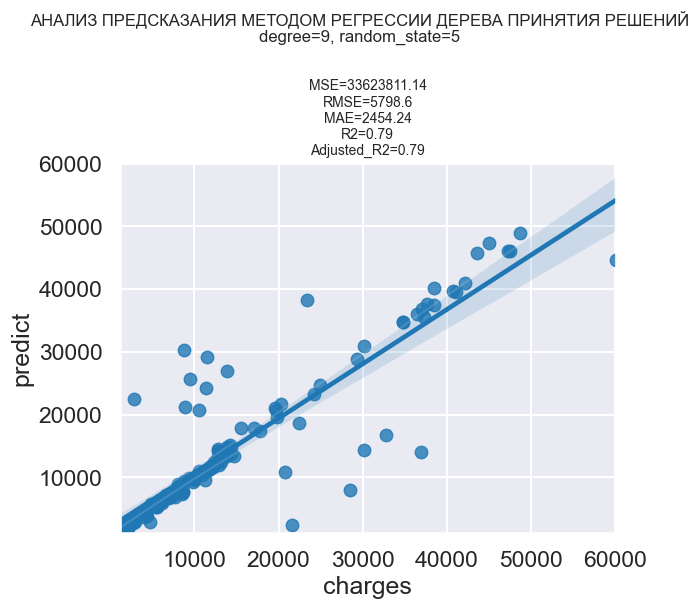

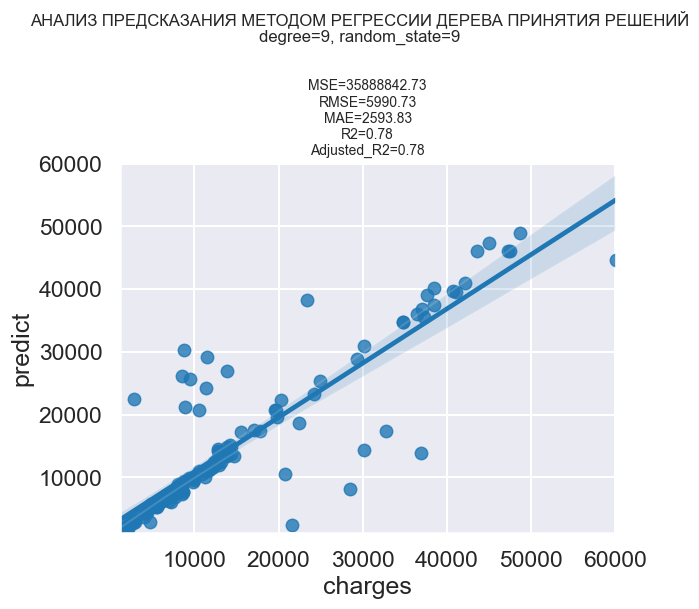

In [33]:
# словарь дерева решений
tree_metrics_dict = {}

# ПОСТРОЕНИЕ РЕГРЕССОРА ДЕРЕВА РЕШЕНИЙ
for degree in range(1,11,4):
    for random_state in range(1,11,4):
        _, _, df_tree_metrics = combination_decision_tree(df_train=df_FINAL_TRAIN, df_test=df_FINAL_TEST,
                                                          sc_train_y=sc_y, parameters=important_list,
                                                          degree=degree, random_state=random_state)

        tree_metrics_dict[f"{degree}_{random_state}"] = df_tree_metrics
# словарь метрик
metrics_dict['tree'] = tree_metrics_dict


***
### **2.6. SVК (Kernels)**


#### **2.6.1. Анализ предсказания SVR (LINEAR)**

Модель показывает результат хуже предыдущих моделей. При этом наблюдается интересное поведение предсказаний при изменении параметров SVK. Прии высоких значениях RMSE предсказания выстраиваются в горизонтальную линию, что говорит об едином значении величины предсказания не зависимо от целевого параметра. Это говорит о плохоё и неподходящей модели.


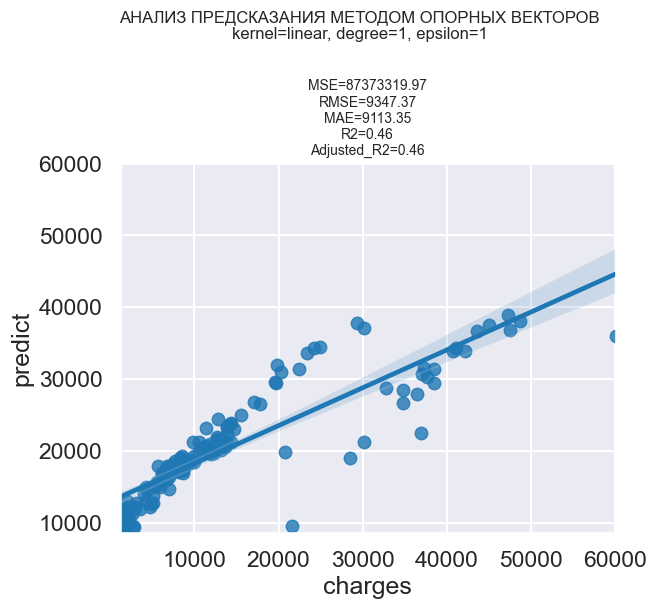

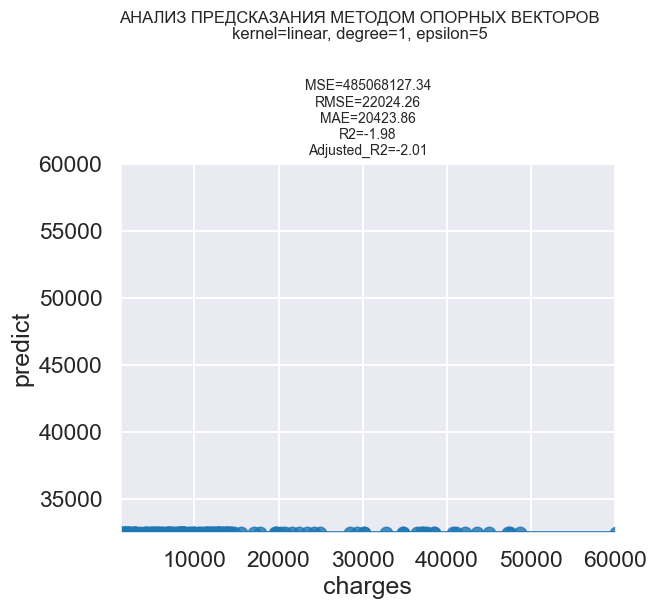

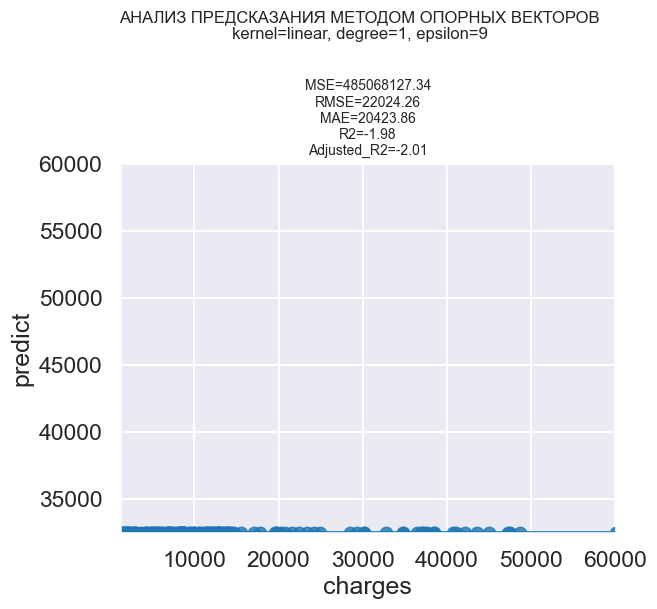

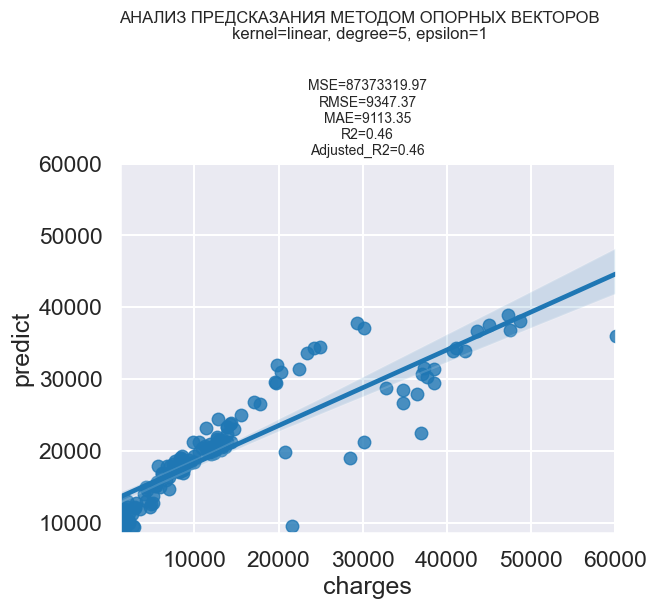

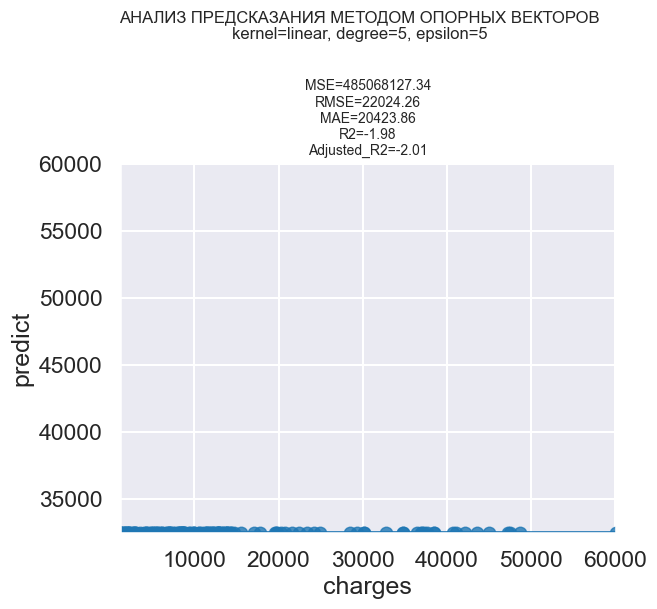

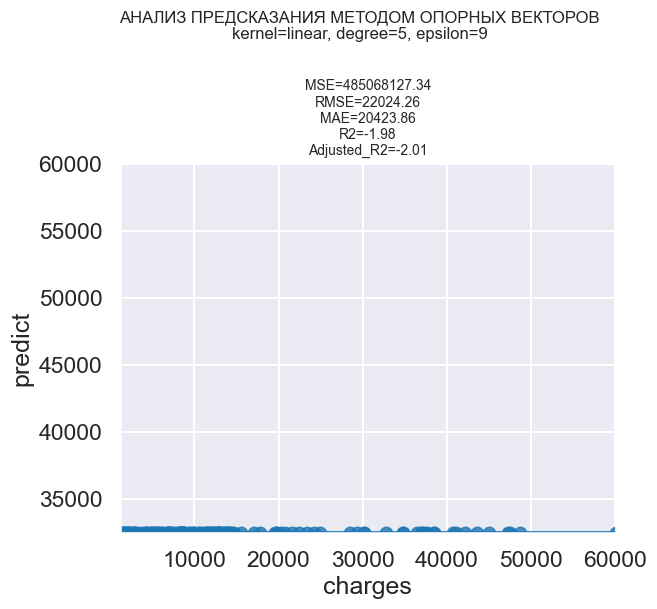

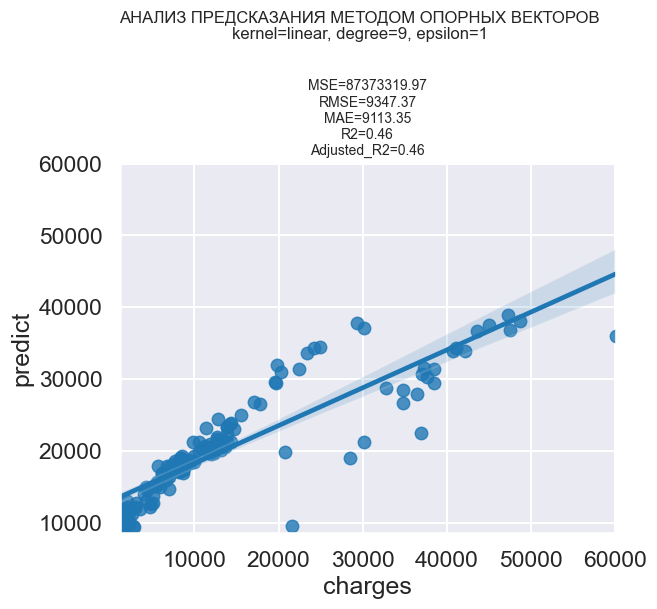

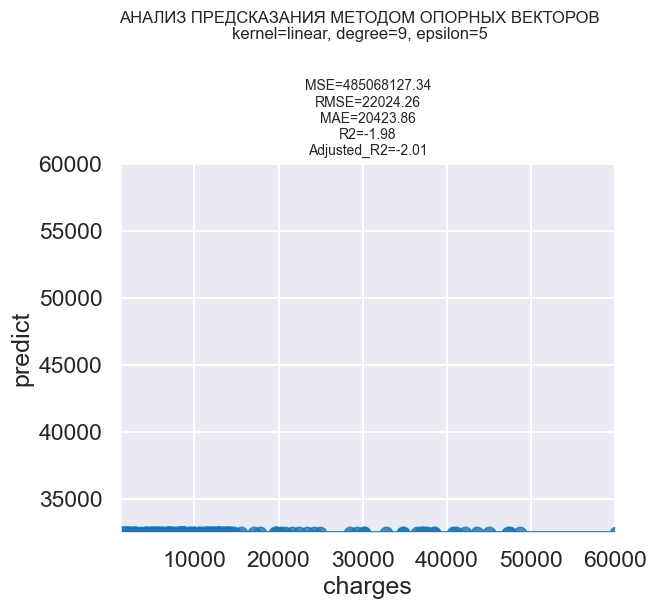

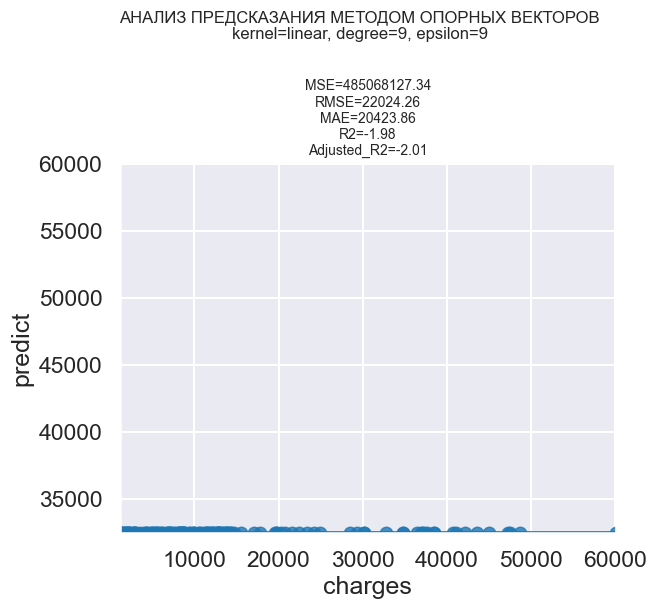

In [34]:
svm_metrics_dict = {}
# МЕТОД ОПОРНЫХ ВЕКТОРОВ (KERNELS)
for degree in range(1,11,4):
    for epsilon in range(1,11,4):
        _, _, df_svm_metrics = combination_svm(df_train=df_FINAL_TRAIN, df_test=df_FINAL_TEST,
                                               sc_train_y=sc_y, parameters=important_list,
                                               kernel="linear", degree=degree, epsilon=epsilon)
        svm_metrics_dict[f"linear_{degree}_{epsilon}"] = df_svm_metrics
# словарь метрик
metrics_dict['svm'] = svm_metrics_dict



***
#### **2.6.2. Анализ предсказания SVR (POLY)**

Модель показывает лучшие результаты по сравнению с предыдущей. Но не выделяется на фоне всех обученных моделей. Очень много рассеянных далеко стоящих предсказаний от линии регрессии. 

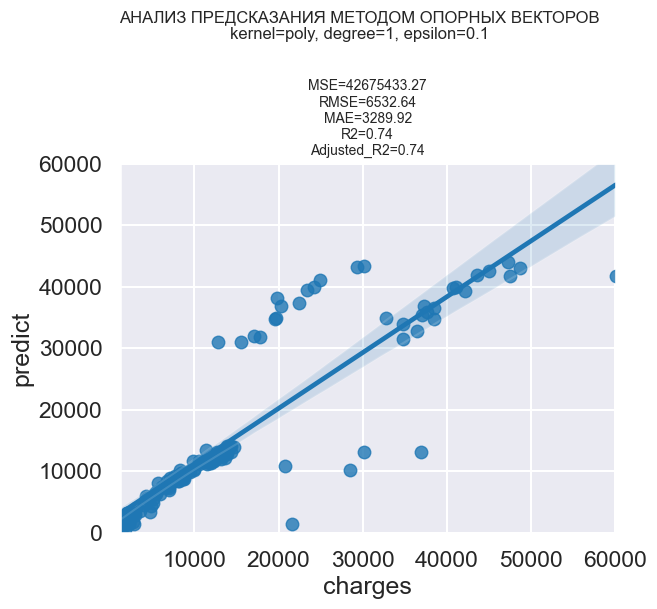

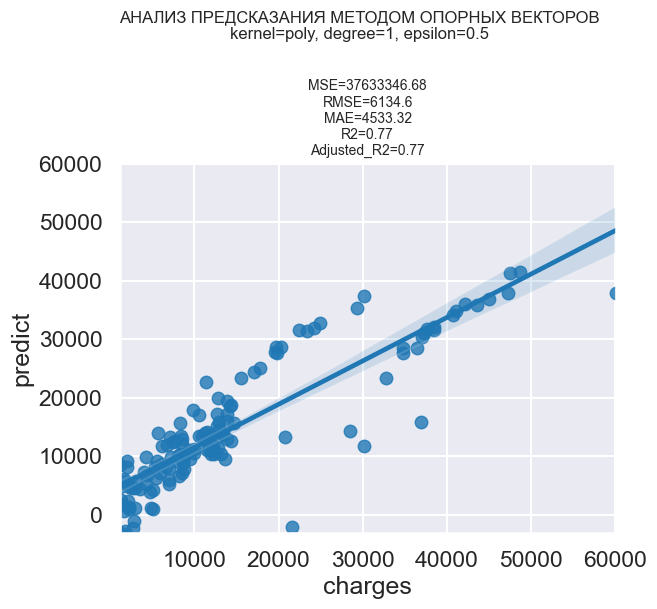

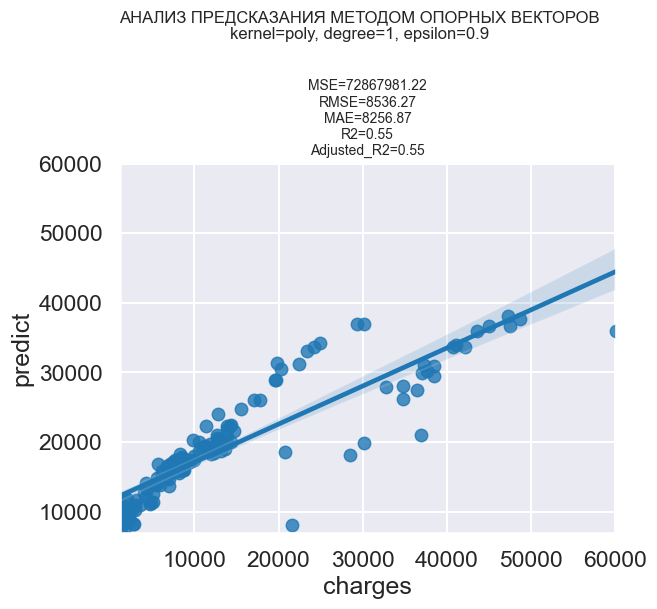

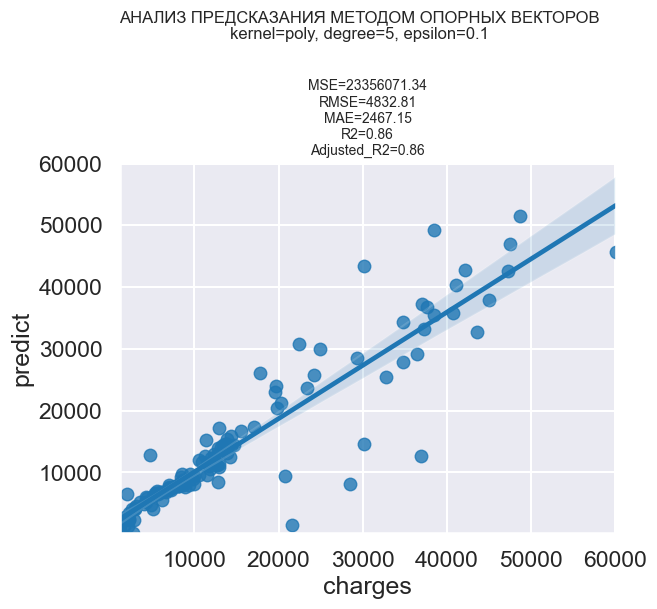

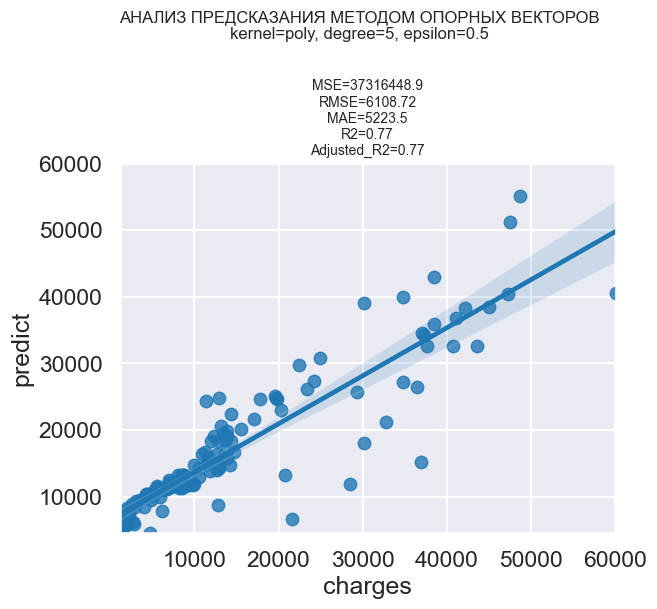

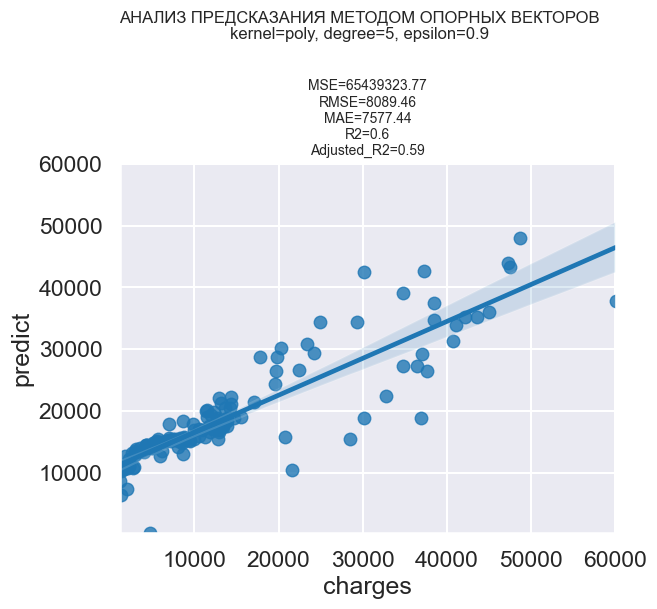

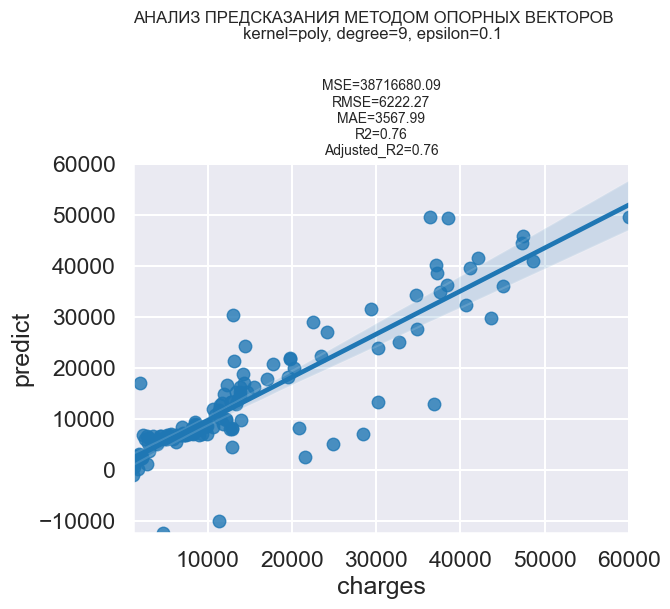

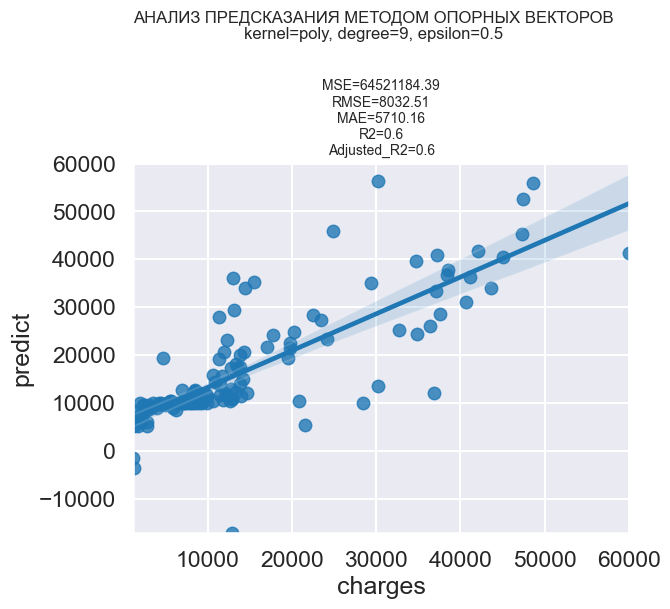

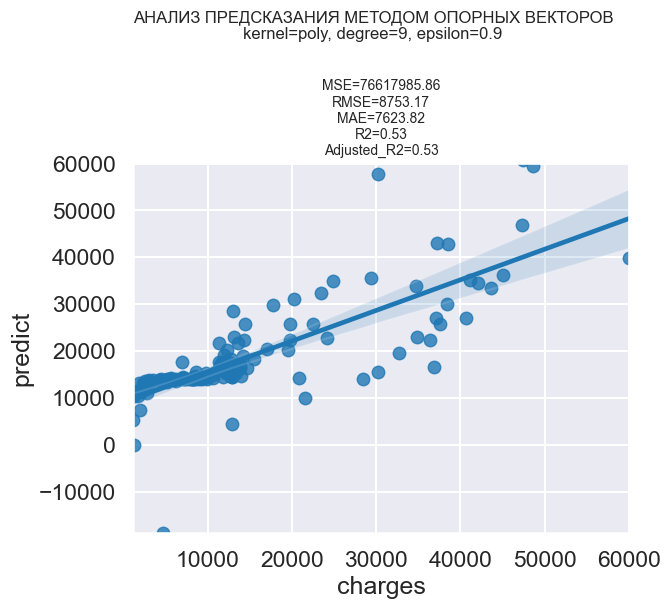

In [35]:
# МЕТОД ОПОРНЫХ ВЕКТОРОВ (KERNELS)
for degree in range(1,11,4):
    for epsilon in np.arange(0.1,1,0.4):
        _, _, df_svm_metrics= combination_svm(df_train=df_FINAL_TRAIN, df_test=df_FINAL_TEST,
                                              sc_train_y=sc_y, parameters=important_list,
                                              kernel="poly", degree=degree, epsilon=epsilon)

        svm_metrics_dict[f"poly_{degree}_{epsilon}"] = df_svm_metrics
# словарь метрик
metrics_dict['svm'] = svm_metrics_dict



***
### **2.7. GaussianNB**

Возможно, по причине того, что данная модель предназначена для классификации, она показала худшие результаты в определении цены дома с большими ошибками. Поведение схоже с моделью *SVR (LINEAR)*.

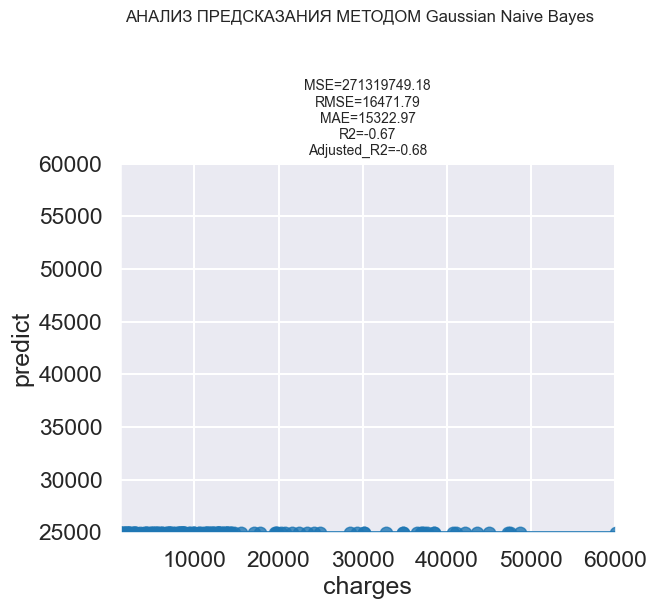

In [36]:
# ФУНКЦИЯ ПОСТРОЕНИЯ ГРАФИКОВ РЕГРЕССИИ Gaussian Naive Bayes
_, _, df_gnb_metrics = combination_gnb(df_train=df_FINAL_TRAIN, df_test=df_FINAL_TEST,
                                       parameters=important_list, sc_train_y=sc_y)

# словарь метрик
metrics_dict['gnb'] = [df_gnb_metrics]


***
### **2.8. Isotonic Regression**

Упорядочивает значения одной переменной относительно другой. Не смотря на то, что подходит для нелинейных зависимостей данных, показала полохие результаты.

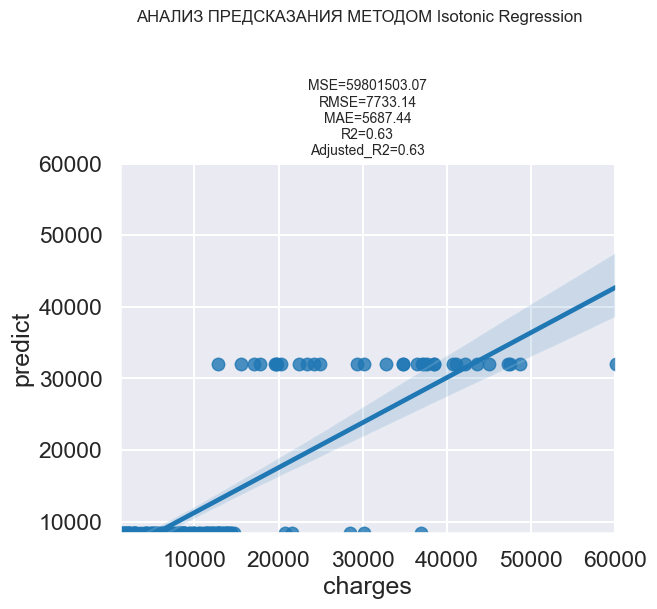

In [37]:
# ФУНКЦИЯ ПОСТРОЕНИЯ ГРАФИКОВ РЕГРЕССИИ Isotonic Regression
_, _, df_iso = combination_iso(df_train=df_FINAL_TRAIN, df_test=df_FINAL_TEST, parameters=important_list[0], sc_train_y=sc_y)

# словарь метрик
metrics_dict['iso'] = [df_iso]


# **3. <span style="color: red;">СРАВНЕНИЕ МОДЕЛЕЙ НА ОСНОВЕ МЕТРИК РЕГРЕССИИ</span>**

### **3.1. СРАВНЕНИЕ МЕТРИК**

In [38]:
# таблица метрик
df_comparison = df_metrics_construct(metrics_dict=metrics_dict)
df_comparison

MSE     RMSE      MAE    R2  Adjusted_R2
forest_9_5            20217925.02  4496.43  2164.92  0.88         0.87
forest_9_1            20680921.03  4547.63  2296.77  0.87         0.87
forest_5_1            21727475.25  4661.27  2408.32  0.87         0.87
svm_poly_5_0.1        23356071.34  4832.81  2467.15  0.86         0.86
forest_5_5            24202394.77  4919.59  2302.41  0.85         0.85
forest_5_9            24946811.03  4994.68  2572.09  0.85         0.85
forest_9_9            25010352.45  5001.04  2627.72  0.85         0.85
forest_1_9            30131654.19  5489.23  2362.08  0.81         0.81
tree_1_5              33623811.14  5798.60  2454.24  0.79         0.79
tree_9_5              33623811.14  5798.60  2454.24  0.79         0.79
tree_5_5              33623811.14  5798.60  2454.24  0.79         0.79
tree_1_9              35888842.73  5990.73  2593.83  0.78         0.78
tree_5_9              35888842.73  5990.73  2593.83  0.78         0.78
tree_9_9              35888842.73  5990.73  2593.83  0.78         0.78
tree_1_1              35981379.21  5998.45  2584.47  0.78         0.78
tree_5_1              35981379.21  5998.45  2584.47  0.78         0.78
tree_9_1              35981379.21  5998.45  2584.47  0.78         0.78
forest_1_5            36703182.99  6058.32  2600.02  0.77         0.77
svm_poly_5_0.5        37316448.90  6108.72  5223.50  0.77         0.77
svm_poly_1_0.5        37633346.68  6134.60  4533.32  0.77         0.77
svm_poly_9_0.1        38716680.09  6222.27  3567.99  0.76         0.76
svm_poly_1_0.1        42675433.27  6532.64  3289.92  0.74         0.74
forest_1_1            46727784.53  6835.77  3313.61  0.71         0.71
iso                   59801503.07  7733.14  5687.44  0.63         0.63
simple                59801783.79  7733.16  5687.43 -0.02        -0.02
polinomial_degree_2   63373604.98  7960.75  6321.77  0.61         0.61
polinomial_degree_6   63813475.11  7988.33  6321.03  0.61         0.60
polinomial_degree_8   63813475.11  7988.33  6321.03  0.61         0.60
polinomial_degree_20  63813475.11  7988.33  6321.03  0.61         0.60
polinomial_degree_10  63813475.11  7988.33  6321.03  0.61         0.60
svm_poly_9_0.5        64521184.39  8032.51  5710.16  0.60         0.60
svm_poly_5_0.9        65439323.77  8089.46  7577.44  0.60         0.59
polinomial_degree_4   65608063.75  8099.88  6411.44  0.60         0.59
svm_poly_1_0.9        72867981.22  8536.27  8256.87  0.55         0.55
svm_poly_9_0.9        76617985.86  8753.17  7623.82  0.53         0.53
svm_linear_1_1        87373319.97  9347.37  9113.35  0.46         0.46
svm_linear_5_1        87373319.97  9347.37  9113.35  0.46         0.46
svm_linear_9_1        87373319.97  9347.37  9113.35  0.46         0.46
multiple             145030992.02 12042.88  9501.90  0.11         0.10
gnb                  271319749.18 16471.79 15322.97 -0.67        -0.68
svm_linear_1_9       485068127.34 22024.26 20423.86 -1.98        -2.01
svm_linear_9_5       485068127.34 22024.26 20423.86 -1.98        -2.01
svm_linear_5_9       485068127.34 22024.26 20423.86 -1.98        -2.01
svm_linear_5_5       485068127.34 22024.26 20423.86 -1.98        -2.01
svm_linear_1_5       485068127.34 22024.26 20423.86 -1.98        -2.01
svm_linear_9_9       485068127.34 22024.26 20423.86 -1.98        -2.01

### **3.2. Динамика метрик регрессий**

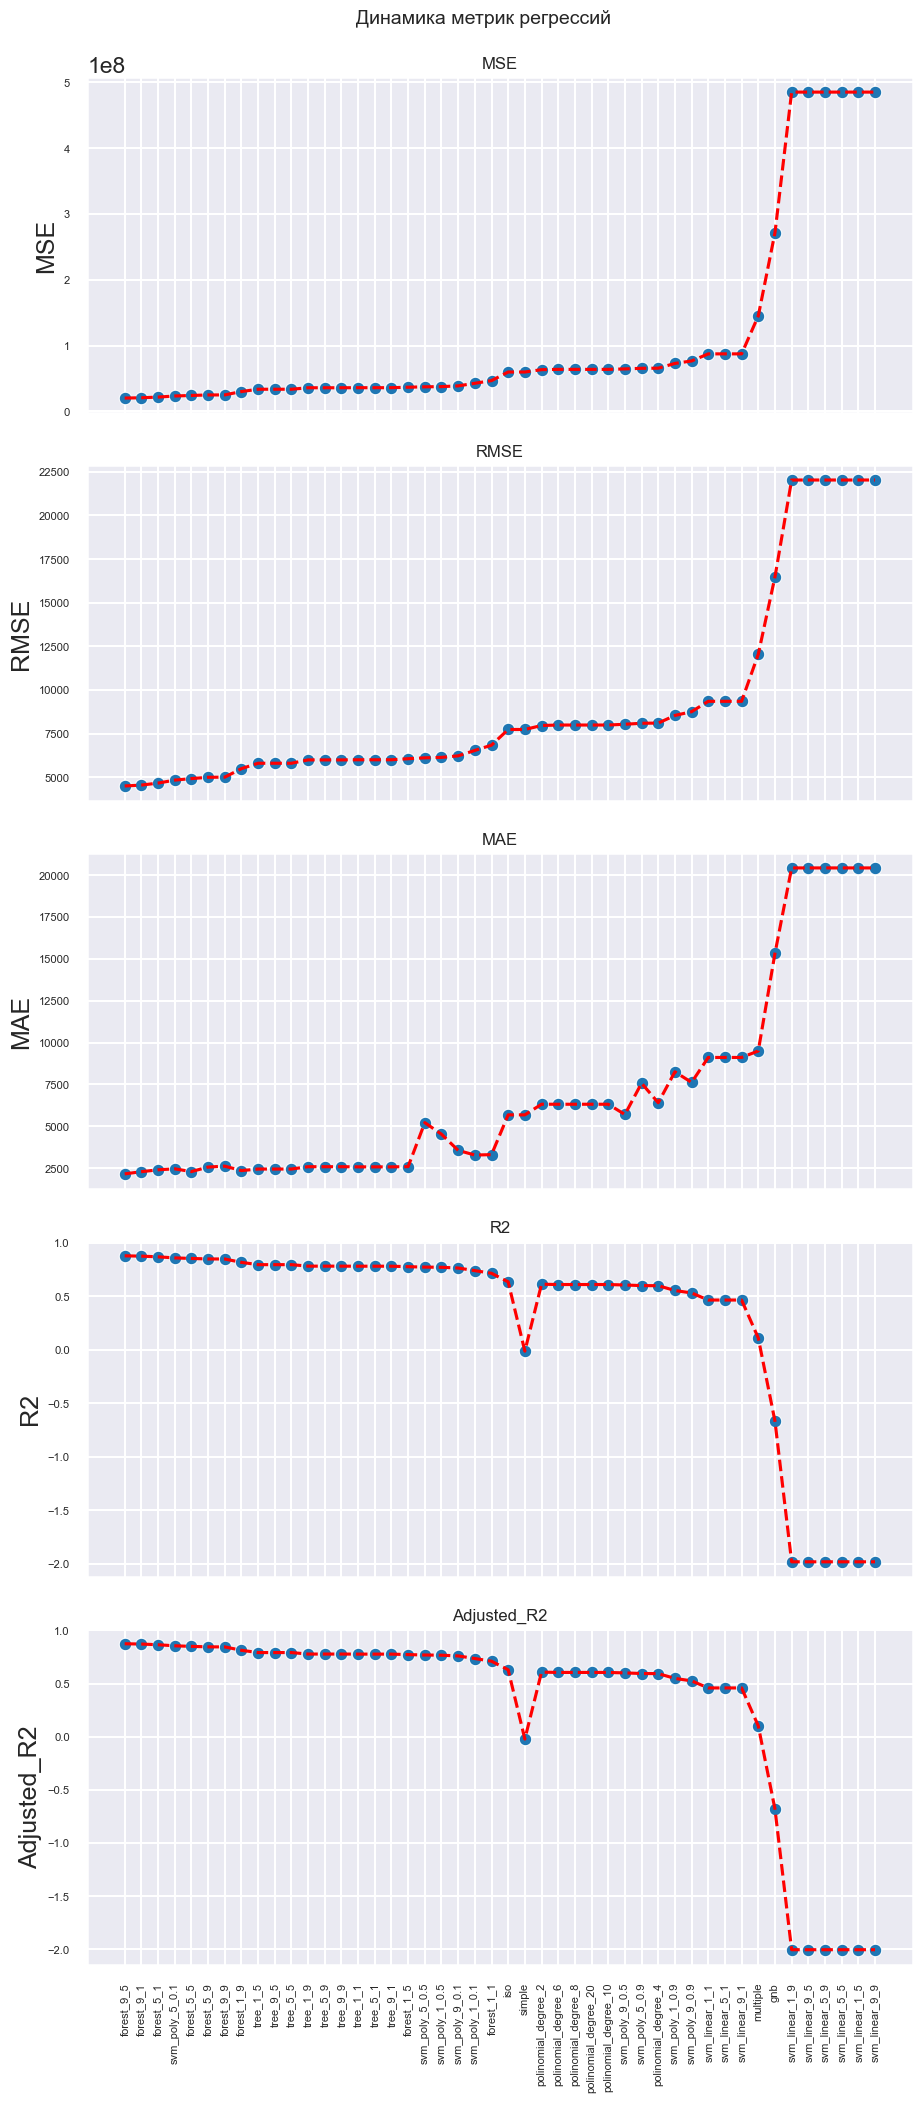

In [39]:
# Динамика метрик регрессий
fig, axs = plt.subplots(5,1, sharex=True, figsize=(10,20))
for key, val in enumerate(METRICS_LIST):
    axs[key].set_title(val, fontsize=12);
    axs[key].plot(df_comparison[val], "r--");          # график 1
    sns.scatterplot(df_comparison[val], ax=axs[key]);  # график 2

    axs[key].tick_params(axis='y', labelsize=8)
    plt.tight_layout();

fig.suptitle("Динамика метрик регрессий", fontsize=14, y=1.01)
# plt.yticks(fontsize=8);
plt.xticks(rotation=90, fontsize=8);

***
### **3.3. <span style="color: red;">РЕЗЮМЕ</span>**

Все модели показали плохие результаты.

**Наилучшие** показатели у `Random Forest` (*n_estimators=9, random_state=5*).	

Ни одна модель не рекомендуется к предсказанию стоимости медецинских расходов. Требуется дополнительное изучение моделей с нелинейным поведением.